### **Text to SQL: Natural Language to Athena Query Execution**

### Description:
This application allows users to interact with a database using natural language queries. 

Users can ask questions in plain English, and the system will convert the question into an SQL query. This query is then executed on an Amazon Athena database. Once the query is executed, the results are translated back into natural language, providing an easy-to-understand response. 

This workflow enables users to interact with databases without needing to write complex SQL, making it more accessible for non-technical users.

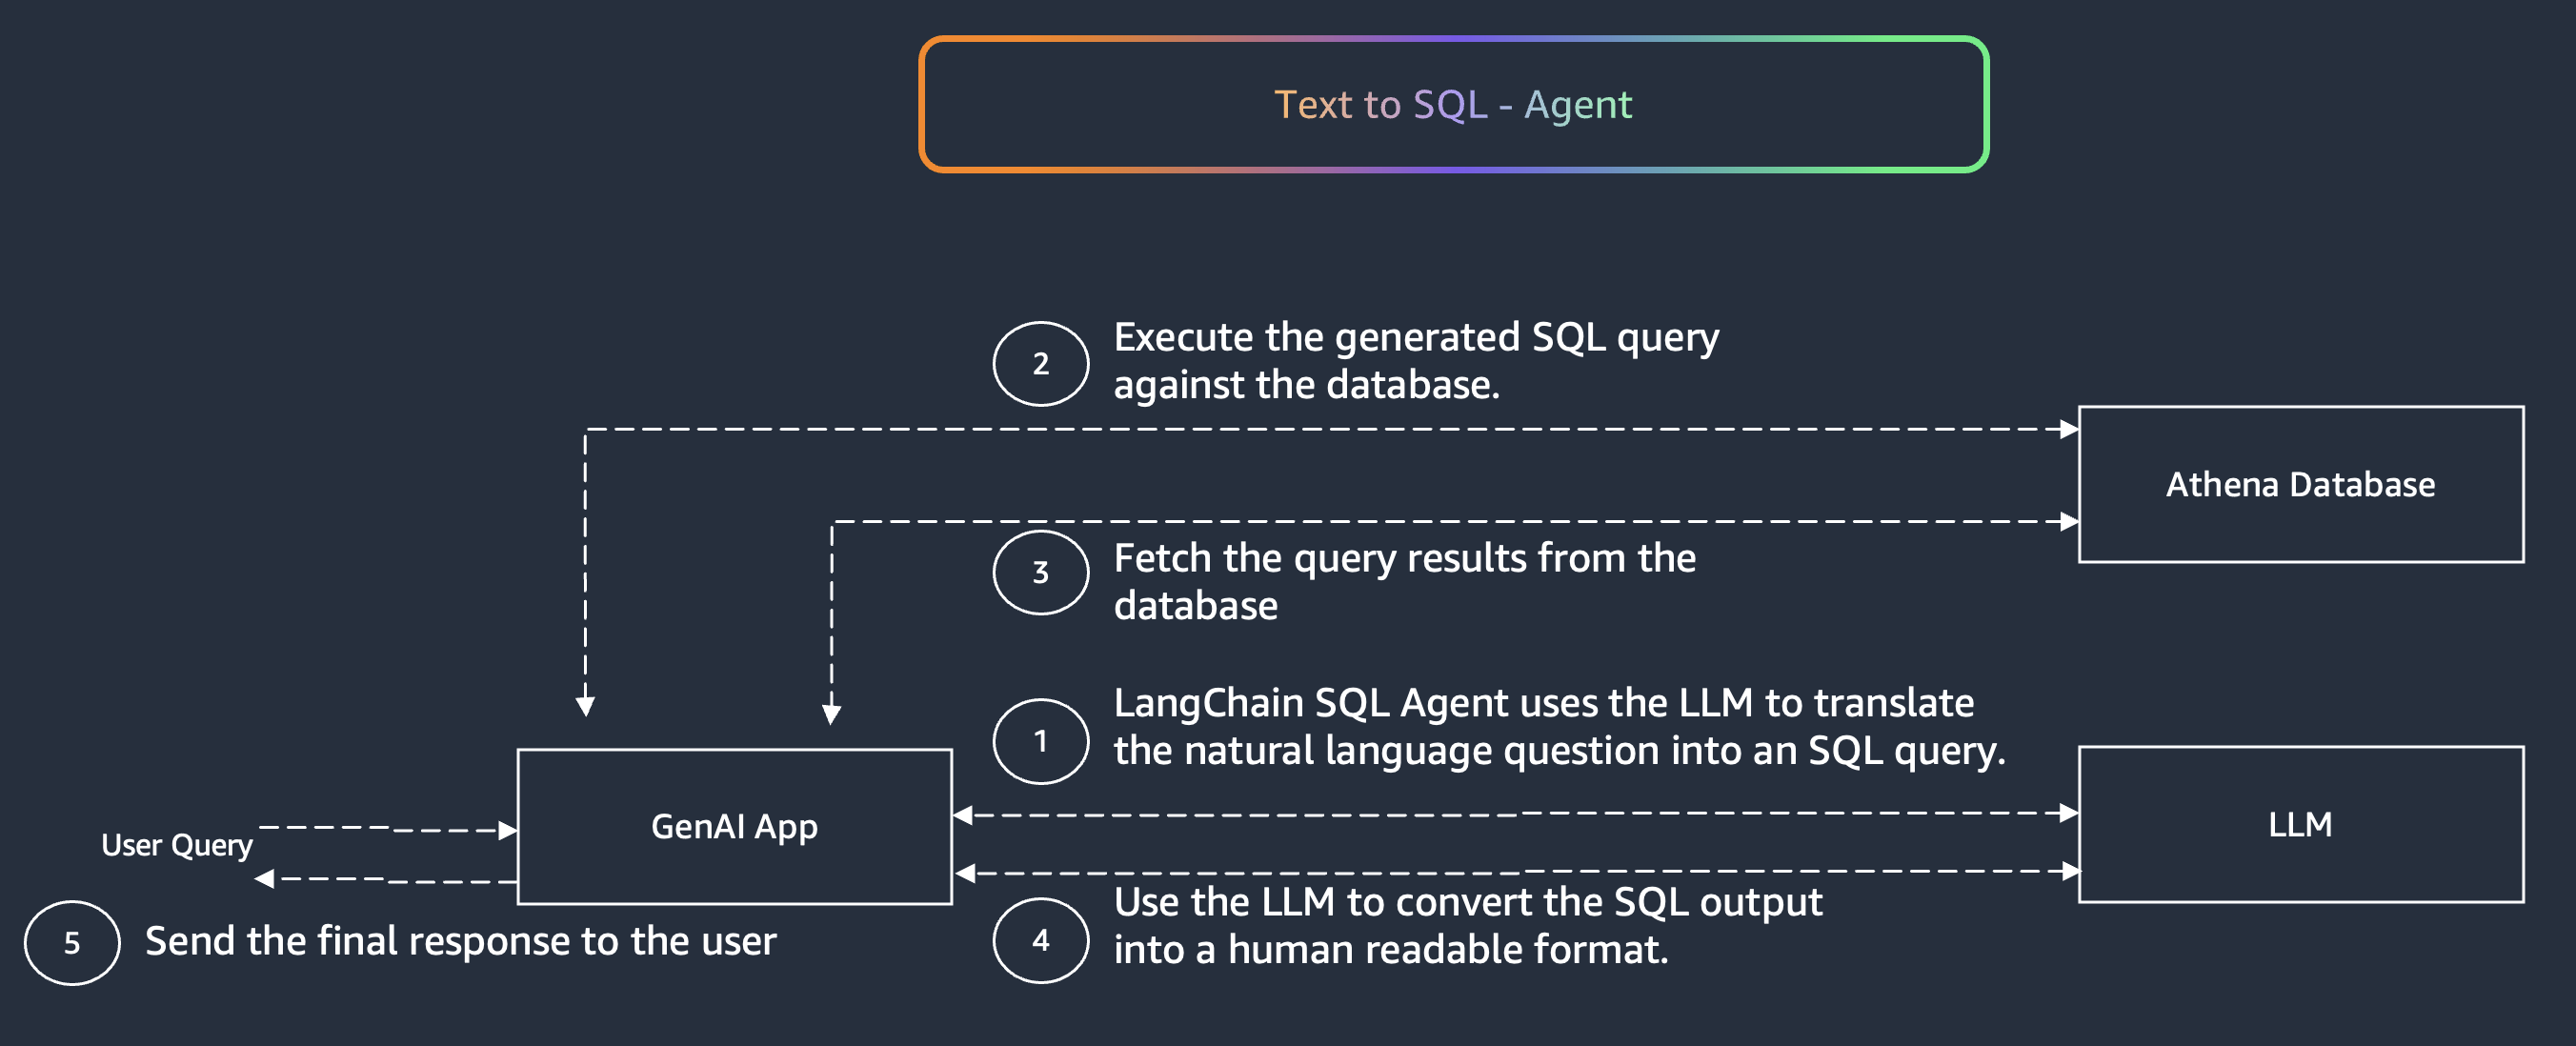

In [ ]:
%pip install -r requirements.txt --quiet --upgrade

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Data Query Assistant

In [2]:
# First, let's import all necessary libraries
import boto3
from sqlalchemy import create_engine
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_aws import ChatBedrock
from langchain_community.agent_toolkits import create_sql_agent, SQLDatabaseToolkit
from langchain.agents import AgentType
from langchain_core.prompts import ChatPromptTemplate
from langchain.callbacks.base import BaseCallbackHandler

# 1: Create a Callback Handler to Capture SQL Queries

In [3]:
class SQLHandler(BaseCallbackHandler):
    """Callback handler to capture the SQL query generated by the agent"""
    def __init__(self):
        self.sql_query = None

    def on_agent_action(self, action, **kwargs):
        if action.tool == "sql_db_query":
            self.sql_query = action.tool_input

# 2: Configure AWS Bedrock Model

In [4]:
# Set your AWS region
region = 'us-west-2'

# ChatBedrock Configuration
model_id = "us.amazon.nova-pro-v1:0"
model_kwargs = {
    "max_tokens": 4096,
    "temperature": 0.0,
    "top_k": 250,
    "top_p": 1
}

# 3: Set Up Athena Connection

In [5]:
# Athena Configuration
import os
athena_workgroup = 'primary'

session = boto3.session.Session()
region = session.region_name
account_id = session.client('sts').get_caller_identity()['Account']
athena_query_result_bucket = f"{account_id}-{region}-athena-output"
athena_query_result_location = f"s3://{athena_query_result_bucket}/athena-query-results/"
db_name = "retail"

print("athena_query_result_location")
print(athena_query_result_location)
def create_athena_engine(aws_region, athena_workgroup, athena_query_result_location, db_name):
    """Create a connection to AWS Athena"""
    athena_endpoint = f'athena.{aws_region}.amazonaws.com'
    athena_conn_string = (
        f"awsathena+rest://@{athena_endpoint}:443/{db_name}"
        f"?s3_staging_dir={athena_query_result_location}&work_group={athena_workgroup}"
    )
    athena_engine = create_engine(athena_conn_string, echo=False)
    return SQLDatabase(athena_engine)

athena_query_result_location
s3://859755744029-us-east-1-athena-output/athena-query-results/


# 4: Create Bedrock LLM

In [6]:
def create_bedrock_llm(model_id, model_kwargs):
    """Create a LangChain wrapper for AWS Bedrock"""
    bedrock_runtime = session.client(service_name="bedrock-runtime",
                                   region_name=region)
    return ChatBedrock(
        client=bedrock_runtime,
        model_id=model_id,
        model_kwargs=model_kwargs
    )

# 5: Create SQL Agent

In [7]:
def create_agent(db, llm, verbose = False):
    """Create a SQL agent with the database toolkit"""
    sql_toolkit = SQLDatabaseToolkit(llm=llm, db=db)
    agent_kwargs = {
        "handle_parsing_errors": True,
        "handle_sql_errors": True,
        "return_intermediate_steps": True
    }
    return create_sql_agent(
        llm=llm,
        toolkit=sql_toolkit,
        agent_executor_kwargs=agent_kwargs,
        agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=verbose  # Set to True to see the agent's thought process
    )

# 6: Define the Prompt Template

In [8]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", """
    You are an expert in Amazon Athena.
    You have access to the live database to query.
    To answer this question, 
        you will first need to get the schema of the relevant tables to see what columns are available.
    Then query the relevant tables in the database to come up with Final Answer.
    Do not assume any values for the data.
    Use [sql_db_list_tables] to get a list of tables in the database.
    Use [sql_db_schema] to get the schema for these tables.
    Use [sql_db_query_checker] to validate the SQL query.
    Execute the query using [sql_db_query] tool and observe the output.
    Always provide the explanation and assumptions that you have made to come up with the output.
    For forecasting questions:
    - There won't be any data available for the future dates. So, identify historical data trends.
    - Use appropriate methods to forecast future values based on historical data.
    - Clearly explain the forecasting methodology and results.\
    """
    ),
    ("human", "{context}"),
])

# 7: Function to Invoke the Agent

In [9]:
import time
import random

def invoke_agent(agent, question, max_retries=5, base_delay=5, max_delay=60):
    """
    Invoke the agent with a question and return both SQL and output with retry backoff.
    
    Args:
        agent: The agent to invoke
        question: The question to ask
        max_retries: Maximum number of retry attempts
        base_delay: Initial delay in seconds
        max_delay: Maximum delay in seconds
    
    Returns:
        Tuple of (sql_query, output) or (None, error_message) if all retries fail
    """
    handler = SQLHandler()
    prompt = prompt_template.invoke(question)
    
    attempt = 0
    last_exception = None
    
    while attempt <= max_retries:
        try:
            # Attempt to invoke the agent
            response = agent.invoke({"input": prompt}, {"callbacks": [handler]})
            output = response['output']
            sqlquery = handler.sql_query
            
            # If successful, return the results
            print(f"Agent invocation successful on attempt {attempt+1}")
            return sqlquery, output
            
        except Exception as e:
            last_exception = e
            attempt += 1
            
            # Check if we've reached the retry limit
            if attempt > max_retries:
                break
            
            # Check if this is a throttling error by examining the exception message
            is_throttling = "ThrottlingException" in str(e) or "Too many requests" in str(e)
            
            # Calculate delay with exponential backoff and jitter
            if is_throttling:
                # For throttling, use a more aggressive backoff strategy
                delay = min(base_delay * (4 ** (attempt - 1)) + random.uniform(0, 2), max_delay)
                print(f"Throttling detected on attempt {attempt}. Backing off for {delay:.2f} seconds...")
            else:
                # For other errors, use standard exponential backoff
                delay = min(base_delay * (2 ** (attempt - 1)) + random.uniform(0, 1), max_delay)
                print(f"Agent invocation attempt {attempt} failed. Retrying in {delay:.2f} seconds...")
                
            # Wait before retrying
            time.sleep(delay)
    
    # If we've exhausted all retries, provide a graceful message instead of raising an exception
    if "ThrottlingException" in str(last_exception) or "Too many requests" in str(last_exception):
        error_message = "Unable to get a response from the agent due to service throttling. The service is currently experiencing high demand. Please try again in a few minutes or reduce request frequency."
    else:
        error_message = f"Unable to get a response from the agent after {max_retries} attempts. Error: {str(last_exception)}"
    
    print(error_message)
    
    # Return None for SQL query and the error message as output
    return None, error_message

# 8: Put Everything Together

In [10]:
# Create Athena engine
db = create_athena_engine(region, athena_workgroup, athena_query_result_location, db_name)

# Create the LLM and agent
llm = create_bedrock_llm(model_id, model_kwargs)
agent = create_agent(db, llm, verbose=True)


# 9: Example Queries

In [11]:
db.run("SELECT * FROM orders LIMIT 5")

'[(32298, \'CA-2012-124891\', None, None, \'Same Day\', \'RH-19495\', \'Rick Hansen\', \'Consumer\', \'New York City\', \'New York\', \'United States\', 10024.0, \'US\', \'East\', \'TEC-AC-10003033\', \'Technology\', \'Accessories\', \'Plantronics CS510 - Over-the-Head monaural Wireless Headset System\', 2309.65, 7, 0.0, 762.1844999999998, 933.57, \'Critical\'), (26341, \'IN-2013-77878\', None, None, \'Second Class\', \'JR-16210\', \'Justin Ritter\', \'Corporate\', \'Wollongong\', \'New South Wales\', \'Australia\', None, \'APAC\', \'Oceania\', \'FUR-CH-10003950\', \'Furniture\', \'Chairs\', \'"Novimex Executive Leather Armchair\', None, 3709, 9.0, 0.1, -288.765, \'923.63\'), (25330, \'IN-2013-71249\', None, None, \'First Class\', \'CR-12730\', \'Craig Reiter\', \'Consumer\', \'Brisbane\', \'Queensland\', \'Australia\', None, \'APAC\', \'Oceania\', \'TEC-PH-10004664\', \'Technology\', \'Phones\', \'"Nokia Smart Phone\', None, 5175, 9.0, 0.1, 919.9709999999997, \'915.49\'), (13524, \'ES

In [12]:
# Example 1: Simple query
question = "How many transactions are recorded in the order table?"
sql_query, output = invoke_agent(agent, question)

print("SQL Query:")
print(sql_query)
print("\nOutput:")
print(output)



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: ""

Observationorders, returnsThought: I have the list of tables in the database. The 'orders' table is likely to contain the transaction data. I should now get the schema for the 'orders' table to see what columns are available.
Action: sql_db_schema
Action Input: "orders"

ObservationError: table_names {'orders"\n\nObservation'} not found in databaseThought: It seems there was an error in retrieving the schema for the 'orders' table. I should double-check the table names and try again.

Action: sql_db_list_tables
Action Input: ""orders, returnsThought: The list of tables is correct, and the 'orders' table is indeed present. I will try to get the schema again, ensuring that I use the correct syntax.

Action: sql_db_schema
Action Input: "orders"

ObservationError: table_names {'orders"\n\nObservation'} not found in databaseThought: It seems there is a persistent issue with retrieving the schema for th

KeyboardInterrupt: 

In [ ]:
# Example 2: Simple query with aggregation
question = "Find the total number of transactions per country."
sql_query, output = invoke_agent(agent, question)

print("SQL Query:")
print(sql_query)
print("\nOutput:")
print(output)

In [ ]:
# Example 3: Simple query with aggregation.
question = "What is the most purchased product in the UK?"
sql_query, output = invoke_agent(agent, question)

print("SQL Query:")
print(sql_query)
print("\nOutput:")
print(output)

In [ ]:
# Example 4: JOIN operations
question = "Which country has the most returned orders?"
sql_query, output = invoke_agent(agent, question)

print("SQL Query:")
print(sql_query)
print("\nOutput:")
print(output)

In [ ]:
# Example 5: Use Common Table Expressions (CTE)
question = "Which product categories were the most common ones in the top 3 countries with the most returned orders."
sql_query, output = invoke_agent(agent, question)

print("SQL Query:")
print(sql_query)
print("\nOutput:")
print(output)

#### In ordr to see the thoughts process that SQLAgent created, turn on "verbose" option for the agent

In [ ]:
verbose_agent = create_agent(db, llm, verbose=True)

In [ ]:
# Example 6: Complex query using JOIN and LIKE.
question = "Find any customer whose name is Justin and returned a furniture in 2013."

question = f"""Identify if the QUESTION specified has multiple sub questions. For each subquestion, think step by step and identify the right tables and columns while creating a SQL query.

QUESTION: {question}"""
sql_query, output = invoke_agent(verbose_agent, question)

print("SQL Query:")
print(sql_query)
print("\nOutput:")
print(output)